#### 1. Install Dependencies

In [9]:
pip install -r requirements.txt -q


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### 2. Imports & Helper Functions

In [10]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from time import sleep

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(DDGS().images(keywords=term, max_results=max_images)).itemgot('image')

def download_and_resize(searches, path, count=50):
    for s in searches:
        dest = (path/s)
        dest.mkdir(exist_ok=True, parents=True)    
        download_images(dest, urls=search_images(term=s, max_images=count))
        print(f"Resizing images in '{s}'")
        resize_images(path/s, max_size=400, dest=path/s)

#### 3. Main Logic

In [11]:
# download images & save each image in a folder named after the search term
# i.e. one folder per breed
searches = ['great dane dog', 'golden retriever dog', 'chihuahua dog']
path = Path('dog_breeds')
download_and_resize(searches=searches, path=path, count=10)

# some photos might not download correctly which could cause model training to fail
# remove such broken images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

Searching for 'great dane dog'
Resizing images in 'great dane dog'
Searching for 'golden retriever dog'
Resizing images in 'golden retriever dog'
Searching for 'chihuahua dog'
Resizing images in 'chihuahua dog'


0

Here what each of the DataBlock parameters means:

blocks=(ImageBlock, CategoryBlock): 
- inputs to our model are images, and the outputs are categories
- in this case, it's one of [chihuahua dog, golden retriever dog, great dane dog]

get_items=get_image_files: 
- to find all inputs to our model
- get_image_files function returns a list of all images in specified path recursively

splitter=RandomSplitter(valid_pct=0.2, seed=42): 
- split the data into training and validation sets randomly
- we are using 20% of the data for the validation set

get_y=parent_label: 
- the labels (y values) is the name of the parent dir of each file 
- i.e. the name of the folder they're in which will be one of the dog breeds

item_tfms=[Resize(192, method='squish')]: 
- before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it)

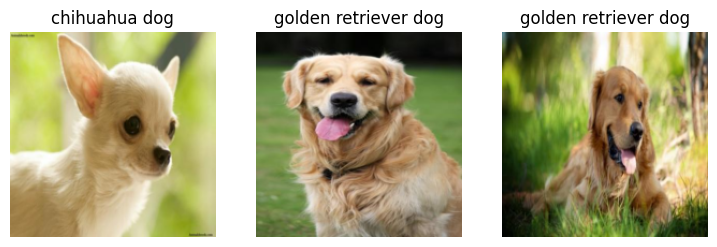

In [12]:
# create data loaders for training
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=10)

# show a few images
dls.show_batch(max_n=3)

#### 4. Train The Model

In [13]:
# fastest widely used computer vision model is resnet18
# this will take a few mins on a CPU 
# on a GPU, it will be much much faster
learn = vision_learner(dls, resnet18, metrics=error_rate)

# fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.590492,0.044262,0.636364,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.236730,0.002591,0.636364,00:01
1,0.144705,0.000475,0.636364,00:01
2,0.103069,0.000509,0.636364,00:01


#### 5. Predict

In [14]:
# download a random great dane image
image = 'great-dane.jpg'
download_url(search_images('happy great dane adult dog', max_images=1)[0], image, show_progress=False)
Image.open(image).to_thumb(256, 256)

# predict the breed & display the confidence level (probability)
breed, _, probs = learn.predict(PILImage.create(image))
print(f"This is a: {breed}.")
print(f"Chihuahua probability: {probs[0]:.4f}")
print(f"Golden Retriever probability: {probs[1]:.4f}")
print(f"Great Dane probability: {probs[2]:.4f}")

Searching for 'happy great dane adult dog'


This is a: great dane dog.
Chihuahua probability: 0.0010
Golden Retriever probability: 0.0021
Great Dane probability: 0.9969
